<a href="https://colab.research.google.com/github/Sakshi-Rani-21/QUANTILE-REGRESSION-BASED-LSTM-MODEL/blob/main/QRLSTM_0.9quantile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Ensures deterministic behavior

set_seed(42)  # Set a fixed seed

# Load dataset
file_path = "/content/drive/MyDrive/DELHI.xlsx"  # Change path if needed
df = pd.read_excel(file_path)

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Select required columns
selected_features = ["AQI", "tempmax","tempmin", "PM2.5", "PM10", "Max 8-h CO","NO2"]
df_selected = df[["Timestamp"] + selected_features].copy()

# Set Timestamp as index
df_selected.set_index("Timestamp", inplace=True)

# Check for missing values and drop them
df_selected.dropna(inplace=True)

# Split into train (2018-2020) and test (2021)
train_data = df_selected.loc["2020-01-01":"2022-12-31"]
test_data_extended = df_selected.loc["2022-01-01":"2023-06-30"]

# Separate features and target
X_train1 = train_data.copy()
y_train1 = train_data["AQI"]
X_test1 = test_data_extended.copy()
y_test1 = test_data_extended["AQI"]

# Initialize Scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit only on training data, then transform both
X_train_scaled = scaler_X.fit_transform(X_train1)
X_test_scaled = scaler_X.transform(X_test1)
y_train_scaled = scaler_y.fit_transform(y_train1.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test1.values.reshape(-1, 1))

# Convert back to DataFrame for sequence creation
train_scaled = pd.DataFrame(X_train_scaled, columns=X_train1.columns, index=train_data.index)
train_scaled["AQI"] = y_train_scaled
test_scaled = pd.DataFrame(X_test_scaled, columns=X_test1.columns, index=test_data_extended.index)
test_scaled["AQI"] = y_test_scaled

# Define rolling window function
def create_sequences(data, sequence_length=365):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i + sequence_length].values)  # Last 365 days as features
        y.append(data.iloc[i + sequence_length]["AQI"])  # Next day AQI as target
    return np.array(X), np.array(y)

# Generate sequences
X_train, y_train = create_sequences(train_scaled, sequence_length=365)
X_test, y_test = create_sequences(test_scaled, sequence_length=365)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
batch_size = 64  # Increased batch size for faster training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define QRLSTM Model
class QRLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_dim=1, quantiles=[0.97]):
        super(QRLSTM, self).__init__()
        self.quantiles = quantiles
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * len(self.quantiles))

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        x = lstm_out[:, -1, :]  # Take last time step
        x = self.fc(x)  # Fully connected layer
        return x.view(x.shape[0], len(self.quantiles))  # Reshape for multiple quantiles

# Define Quantile Loss
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super(QuantileLoss, self).__init__()
        self.quantiles = torch.tensor(quantiles, dtype=torch.float32)

    def forward(self, preds, target):
        quantiles = self.quantiles.to(target.device)  # Move to same device
        errors = target - preds
        losses = torch.maximum(quantiles * errors, (quantiles - 1) * errors)
        return torch.mean(losses)

# Check for GPU and enable mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QRLSTM(input_dim=7, quantiles=[0.97]).to(device)

# Use the correct way to initialize GradScaler and autocast
scaler = torch.amp.GradScaler("cuda")  # Fixed
criterion = QuantileLoss([0.97]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)



num_epochs = 100  # You can adjust based on training behavior

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    # Compute average training loss
    avg_train_loss = total_loss / len(train_loader)

    # Validation Loss Calculation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")




# Evaluation
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.append(preds.cpu().numpy())  # Move back to CPU
        actuals.append(y_batch.numpy())

# Convert lists to numpy arrays
predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Inverse Transform
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# Define Quantile Loss function
def quantile_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    return np.sum(np.where(error >= 0, quantile * error, (quantile - 1) * error))

# Compute Pseudo R² for Quantile Regression
def pseudo_r2_quantreg(y_pred, y_true, quantile):
    fitted_loss = quantile_loss(y_true, y_pred, quantile)
    null_pred = np.quantile(y_true, quantile)
    null_loss = quantile_loss(y_true, np.full_like(y_true, null_pred), quantile)
    return 1 - (fitted_loss / null_loss)

predictions = predictions
actuals= actuals

quantile = 0.97
pseudo_r2_90 = pseudo_r2_quantreg(predictions, actuals, quantile)
print(f"Pseudo R² (90th Quantile): {pseudo_r2_90:.4f}")



Epoch 1/100, Train Loss: 0.1401, Val Loss: 0.0460
Epoch 2/100, Train Loss: 0.0321, Val Loss: 0.0134
Epoch 3/100, Train Loss: 0.0143, Val Loss: 0.0133
Epoch 4/100, Train Loss: 0.0133, Val Loss: 0.0116
Epoch 5/100, Train Loss: 0.0121, Val Loss: 0.0105
Epoch 6/100, Train Loss: 0.0098, Val Loss: 0.0087
Epoch 7/100, Train Loss: 0.0088, Val Loss: 0.0091
Epoch 8/100, Train Loss: 0.0089, Val Loss: 0.0089
Epoch 9/100, Train Loss: 0.0086, Val Loss: 0.0086
Epoch 10/100, Train Loss: 0.0092, Val Loss: 0.0093
Epoch 11/100, Train Loss: 0.0096, Val Loss: 0.0095
Epoch 12/100, Train Loss: 0.0089, Val Loss: 0.0100
Epoch 13/100, Train Loss: 0.0095, Val Loss: 0.0083
Epoch 14/100, Train Loss: 0.0083, Val Loss: 0.0085
Epoch 15/100, Train Loss: 0.0085, Val Loss: 0.0082
Epoch 16/100, Train Loss: 0.0082, Val Loss: 0.0082
Epoch 17/100, Train Loss: 0.0084, Val Loss: 0.0083
Epoch 18/100, Train Loss: 0.0082, Val Loss: 0.0088
Epoch 19/100, Train Loss: 0.0087, Val Loss: 0.0081
Epoch 20/100, Train Loss: 0.0079, Val Lo

In [ ]:
import numpy as np
from scipy.stats import chi2

# Example: Replace these with your actual AQI values and QRTCN predictions
actuals = actuals
predictions = predictions

# Compute the hit sequence
hit_sequence = (actuals <= predictions).astype(int)  # 1 if actual ≤ predicted, else 0

# Compute N (total number of hits)
N = np.sum(hit_sequence)  # Count of hits

# Compute T (total number of test samples)
T = len(actuals)  # Total test observations

# Expected coverage for 90th quantile
theta = 0.97

# Compute Likelihood Ratio (LR) statistic
LR_UC = 2 * np.log(((N / T) ** N * (1 - N / T) ** (T - N)) /
                   (theta ** N * (1 - theta) ** (T - N)))

# Compute p-value from chi-square distribution (df=1)
p_value = 1 - chi2.cdf(LR_UC, df=1)

# Print results
print(f"Total test observations (T): {T}")
print(f"Number of hits (N): {N}")
print(f"Observed coverage: {N/T:.4f}")
print(f"LR_UC Statistic: {LR_UC:.4f}")
print(f"P-Value: {p_value:.4f}")

# Hypothesis Decision at 5% significance level
alpha = 0.05
if p_value < alpha:
    print("Reject H0: The model does NOT satisfy the UC property (miscalibrated).")
else:
    print("Fail to reject H0: The model satisfies the UC property (well-calibrated).")


Total test observations (T): 181
Number of hits (N): 174
Observed coverage: 0.9613
LR_UC Statistic: 0.4297
P-Value: 0.5121
Fail to reject H0: The model satisfies the UC property (well-calibrated).


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats

class DQTest:
    def __init__(self, actuals, forecast, alpha=0.970):
        """
        Initialize Dynamic Quantile (DQ) test.
        :param actuals: Actual AQI values (numpy array or pandas Series).
        :param forecast: Predicted quantiles from QRTCN.
        :param alpha: Quantile level (e.g., 0.01 for 1% VaR).
        """
        self.actuals = np.array(actuals)
        self.forecast = np.array(forecast)
        self.alpha = alpha

    def hit_series(self):
        """Compute hit series (1 if actual < predicted quantile, else 0)."""
        return (self.actuals < self.forecast).astype(int)

    def dq_bt(self, hit_lags=4, forecast_lags=1):
        """Dynamic Quantile Test (Engle & Manganelli, 2004)"""
        try:
            hits = self.hit_series()
            p, q, n = hit_lags, forecast_lags, hits.size
            pq = max(p, q - 1)
            y = hits[pq:] - self.alpha  # Dependent variable
            x = np.zeros((n - pq, 1 + p + q))
            x[:, 0] = 1  # Constant term

            for i in range(p):  # Lagged hits
                x[:, 1 + i] = hits[pq-(i+1):-(i+1)]

            for j in range(q):  # Forecasts and lags
                if j > 0:
                    x[:, 1 + p + j] = self.forecast[pq-j:-j]
                else:
                    x[:, 1 + p + j] = self.forecast[pq:]
            #print matrix x
            print("Matrix x:")
            print(x)

            # Check for singularity and handle it
            if np.linalg.cond(x.T @ x) > 1e15:  # Check for ill-conditioned matrix
                print("Warning: Singular matrix encountered. Returning NaN.")
                return pd.Series([np.nan, np.nan], index=["Statistic", "p-value"], name="DQ Test")

            # OLS Estimation: beta = (X'X)^(-1) X'Y
            beta = np.linalg.solve(x.T @ x, x.T @ y)  # Using solve instead of inv

            # Avoid division by zero
            denominator = self.alpha * (1 - self.alpha)
            if denominator == 0:
                print("Warning: Division by zero encountered. Returning NaN.")
                return pd.Series([np.nan, np.nan], index=["Statistic", "p-value"], name="DQ Test")

            lr_dq = beta @ (x.T @ x) @ beta / denominator
            p_dq = 1 - stats.chi2.cdf(lr_dq, 1 + p + q)

        except Exception as e:
            print(f"Error during DQ test: {e}")
            lr_dq, p_dq = np.nan, np.nan

        # Format p-value to four decimal places
        p_dq = format(p_dq, ".4f")

        return pd.Series([lr_dq, p_dq], index=["Statistic", "p-value"], name="DQ Test")


# Assuming actuals and predictions are your original arrays
actuals_flat = actuals.flatten()  # Flatten actuals
predictions_flat = predictions.flatten()  # Flatten predictions

# Example: Run DQ Test on QRLSTM Predictions
dq_test = DQTest(actuals=actuals_flat, forecast=predictions_flat, alpha=0.970)
dq_results = dq_test.dq_bt(hit_lags=4, forecast_lags=1)
print(dq_results)

Matrix x:
[[  1.           1.           1.           1.           1.
  389.35293579]
 [  1.           1.           1.           1.           1.
  438.87854004]
 [  1.           1.           1.           1.           1.
  455.57150269]
 ...
 [  1.           1.           1.           1.           1.
  135.65640259]
 [  1.           1.           1.           1.           1.
  170.2956543 ]
 [  1.           1.           1.           1.           1.
  157.38787842]]
Statistic    4.171292
p-value        0.6535
Name: DQ Test, dtype: object


In [ ]:
import numpy as np
import pandas as pd

# Function to assign labels based on AQI ranges
def assign_label(aqi):
    if 0 <= aqi <= 50:
        return 1
    elif 51 <= aqi <= 100:
        return 2
    elif 101 <= aqi <= 200:
        return 3
    elif 201 <= aqi <= 300:
        return 4
    elif 301 <= aqi <= 400:
        return 5
    else:
        return 6

# Apply the function to actual and predicted values
actual_labels = np.array([assign_label(aqi) for aqi in actuals])
predicted_labels = np.array([assign_label(aqi) for aqi in predictions])

# Count datapoints where label_actual > label_pred
count_misclassified = np.sum(actual_labels > predicted_labels)

# Display results
df = pd.DataFrame({
    "Actual AQI": actuals.flatten(),
    "Predicted AQI": predictions.flatten(),
    "Actual Label": actual_labels,
    "Predicted Label": predicted_labels
})

print(df)
print(f"Number of datapoints where actual label > predicted label: {count_misclassified}")

     Actual AQI  Predicted AQI  Actual Label  Predicted Label
0         259.0     335.855743             4                5
1         357.0     380.243805             5                5
2         385.0     397.156097             5                5
3         343.0     439.845337             5                6
4         340.0     389.352936             5                5
..          ...            ...           ...              ...
176        93.0     103.240395             2                3
177        86.0     152.165024             2                3
178        93.0     135.656403             2                3
179       101.0     170.295654             3                3
180        70.0     157.387878             2                3

[181 rows x 4 columns]
Number of datapoints where actual label > predicted label: 1


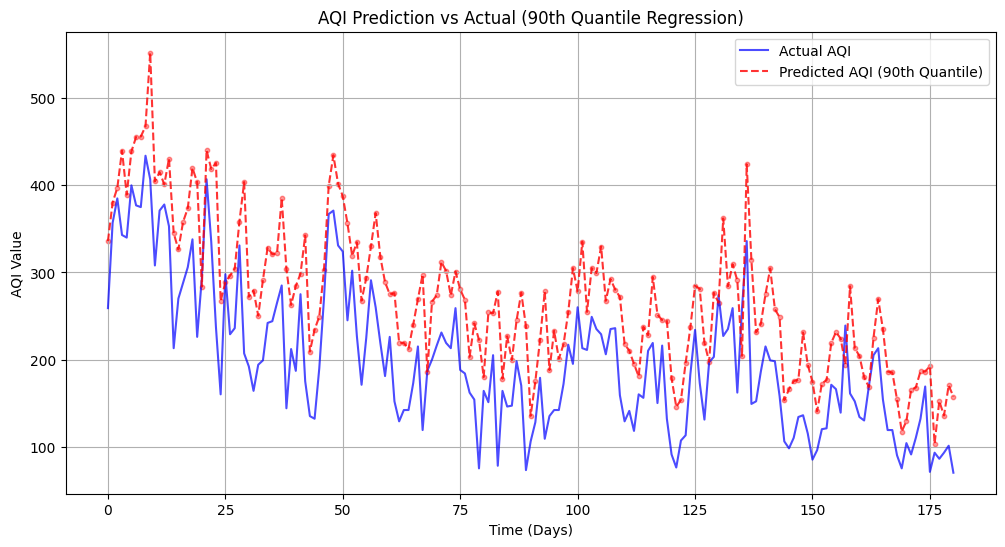

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(actuals, label="Actual AQI", color="blue", linestyle="-", alpha=0.7)

# Plot predicted values
plt.plot(predictions, label="Predicted AQI (90th Quantile)", color="red", linestyle="--", alpha=0.8)

# Scatter plot for better visibility
plt.scatter(range(len(predictions)), predictions, color="red", alpha=0.4, s=10)

# Titles and labels
plt.title("AQI Prediction vs Actual (90th Quantile Regression)")
plt.xlabel("Time (Days)")
plt.ylabel("AQI Value")
plt.legend()
plt.grid(True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Ensures deterministic behavior

set_seed(42)  # Set a fixed seed

# Load dataset
file_path = "/content/drive/MyDrive/DELHI.xlsx"  # Change path if needed
df = pd.read_excel(file_path)

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Select required columns
selected_features = ["AQI", "tempmax","tempmin", "PM2.5", "PM10", "Max 8-h CO","NO2"]
df_selected = df[["Timestamp"] + selected_features].copy()

# Set Timestamp as index
df_selected.set_index("Timestamp", inplace=True)

# Check for missing values and drop them
df_selected.dropna(inplace=True)

# Split into train  and test
train_data = df_selected.loc["2020-07-01":"2023-06-30"]
test_data_extended = df_selected.loc["2022-07-01":"2023-12-31"]

# Separate features and target
X_train1 = train_data.copy()
y_train1 = train_data["AQI"]
X_test1 = test_data_extended.copy()
y_test1 = test_data_extended["AQI"]

# Initialize Scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit only on training data, then transform both
X_train_scaled = scaler_X.fit_transform(X_train1)
X_test_scaled = scaler_X.transform(X_test1)
y_train_scaled = scaler_y.fit_transform(y_train1.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test1.values.reshape(-1, 1))

# Convert back to DataFrame for sequence creation
train_scaled = pd.DataFrame(X_train_scaled, columns=X_train1.columns, index=train_data.index)
train_scaled["AQI"] = y_train_scaled
test_scaled = pd.DataFrame(X_test_scaled, columns=X_test1.columns, index=test_data_extended.index)
test_scaled["AQI"] = y_test_scaled

# Define rolling window function
def create_sequences(data, sequence_length=365):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i + sequence_length].values)  # Last 365 days as features
        y.append(data.iloc[i + sequence_length]["AQI"])  # Next day AQI as target
    return np.array(X), np.array(y)

# Generate sequences
X_train, y_train = create_sequences(train_scaled, sequence_length=365)
X_test, y_test = create_sequences(test_scaled, sequence_length=365)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
batch_size = 64  # Increased batch size for faster training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define QRLSTM Model
class QRLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_dim=1, quantiles=[0.97]):
        super(QRLSTM, self).__init__()
        self.quantiles = quantiles
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * len(self.quantiles))

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        x = lstm_out[:, -1, :]  # Take last time step
        x = self.fc(x)  # Fully connected layer
        return x.view(x.shape[0], len(self.quantiles))  # Reshape for multiple quantiles

# Define Quantile Loss
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super(QuantileLoss, self).__init__()
        self.quantiles = torch.tensor(quantiles, dtype=torch.float32)

    def forward(self, preds, target):
        quantiles = self.quantiles.to(target.device)  # Move to same device
        errors = target - preds
        losses = torch.maximum(quantiles * errors, (quantiles - 1) * errors)
        return torch.mean(losses)

# Check for GPU and enable mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QRLSTM(input_dim=7, quantiles=[0.97]).to(device)

# Use the correct way to initialize GradScaler and autocast
scaler = torch.amp.GradScaler("cuda")  # Fixed
criterion = QuantileLoss([0.97]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping
min_delta = 0.001  # Minimum change in loss to be considered an improvement
best_loss = float("inf")
epochs_no_improve = 0

# Training Loop with Early Stopping
num_epochs = 100  # You can adjust based on training behavior

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    # Compute average training loss
    avg_train_loss = total_loss / len(train_loader)

    # Validation Loss Calculation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


# Evaluation
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.append(preds.cpu().numpy())  # Move back to CPU
        actuals.append(y_batch.numpy())

# Convert lists to numpy arrays
predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Inverse Transform
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# Define Quantile Loss function
def quantile_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    return np.sum(np.where(error >= 0, quantile * error, (quantile - 1) * error))

# Compute Pseudo R² for Quantile Regression
def pseudo_r2_quantreg(y_pred, y_true, quantile):
    fitted_loss = quantile_loss(y_true, y_pred, quantile)
    null_pred = np.quantile(y_true, quantile)
    null_loss = quantile_loss(y_true, np.full_like(y_true, null_pred), quantile)
    return 1 - (fitted_loss / null_loss)

predictions = predictions
actuals= actuals

quantile = 0.97
pseudo_r2_90 = pseudo_r2_quantreg(predictions, actuals, quantile)
print(f"Pseudo R² (90th Quantile): {pseudo_r2_90:.4f}")



Epoch 1/100, Train Loss: 0.1463, Val Loss: 0.0447
Epoch 2/100, Train Loss: 0.0302, Val Loss: 0.0139
Epoch 3/100, Train Loss: 0.0136, Val Loss: 0.0122
Epoch 4/100, Train Loss: 0.0121, Val Loss: 0.0147
Epoch 5/100, Train Loss: 0.0104, Val Loss: 0.0089
Epoch 6/100, Train Loss: 0.0089, Val Loss: 0.0080
Epoch 7/100, Train Loss: 0.0091, Val Loss: 0.0087
Epoch 8/100, Train Loss: 0.0086, Val Loss: 0.0075
Epoch 9/100, Train Loss: 0.0085, Val Loss: 0.0069
Epoch 10/100, Train Loss: 0.0081, Val Loss: 0.0068
Epoch 11/100, Train Loss: 0.0079, Val Loss: 0.0065
Epoch 12/100, Train Loss: 0.0080, Val Loss: 0.0062
Epoch 13/100, Train Loss: 0.0078, Val Loss: 0.0062
Epoch 14/100, Train Loss: 0.0082, Val Loss: 0.0072
Epoch 15/100, Train Loss: 0.0080, Val Loss: 0.0066
Epoch 16/100, Train Loss: 0.0078, Val Loss: 0.0059
Epoch 17/100, Train Loss: 0.0077, Val Loss: 0.0069
Epoch 18/100, Train Loss: 0.0081, Val Loss: 0.0067
Epoch 19/100, Train Loss: 0.0078, Val Loss: 0.0057
Epoch 20/100, Train Loss: 0.0075, Val Lo

In [ ]:
import numpy as np
from scipy.stats import chi2

# Example: Replace these with your actual AQI values and QRTCN predictions
actuals = actuals
predictions = predictions

# Compute the hit sequence
hit_sequence = (actuals <= predictions).astype(int)  # 1 if actual ≤ predicted, else 0

# Compute N (total number of hits)
N = np.sum(hit_sequence)  # Count of hits

# Compute T (total number of test samples)
T = len(actuals)  # Total test observations

# Expected coverage for 90th quantile
theta = 0.97

# Compute Likelihood Ratio (LR) statistic
LR_UC = 2 * np.log(((N / T) ** N * (1 - N / T) ** (T - N)) /
                   (theta ** N * (1 - theta) ** (T - N)))

# Compute p-value from chi-square distribution (df=1)
p_value = 1 - chi2.cdf(LR_UC, df=1)

# Print results
print(f"Total test observations (T): {T}")
print(f"Number of hits (N): {N}")
print(f"Observed coverage: {N/T:.4f}")
print(f"LR_UC Statistic: {LR_UC:.4f}")
print(f"P-Value: {p_value:.4f}")

# Hypothesis Decision at 5% significance level
alpha = 0.05
if p_value < alpha:
    print("Reject H0: The model does NOT satisfy the UC property (miscalibrated).")
else:
    print("Fail to reject H0: The model satisfies the UC property (well-calibrated).")


Total test observations (T): 184
Number of hits (N): 177
Observed coverage: 0.9620
LR_UC Statistic: 0.3778
P-Value: 0.5388
Fail to reject H0: The model satisfies the UC property (well-calibrated).


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats

class DQTest:
    def __init__(self, actuals, forecast, alpha=0.970):
        """
        Initialize Dynamic Quantile (DQ) test.
        :param actuals: Actual AQI values (numpy array or pandas Series).
        :param forecast: Predicted quantiles from QRTCN.
        :param alpha: Quantile level (e.g., 0.01 for 1% VaR).
        """
        self.actuals = np.array(actuals)
        self.forecast = np.array(forecast)
        self.alpha = alpha

    def hit_series(self):
        """Compute hit series (1 if actual < predicted quantile, else 0)."""
        return (self.actuals < self.forecast).astype(int)

    def dq_bt(self, hit_lags=4, forecast_lags=1):
        """Dynamic Quantile Test (Engle & Manganelli, 2004)"""
        try:
            hits = self.hit_series()
            p, q, n = hit_lags, forecast_lags, hits.size
            pq = max(p, q - 1)
            y = hits[pq:] - self.alpha  # Dependent variable
            x = np.zeros((n - pq, 1 + p + q))
            x[:, 0] = 1  # Constant term

            for i in range(p):  # Lagged hits
                x[:, 1 + i] = hits[pq-(i+1):-(i+1)]

            for j in range(q):  # Forecasts and lags
                if j > 0:
                    x[:, 1 + p + j] = self.forecast[pq-j:-j]
                else:
                    x[:, 1 + p + j] = self.forecast[pq:]
            #print matrix x
            print("Matrix x:")
            print(x)

            # Check for singularity and handle it
            if np.linalg.cond(x.T @ x) > 1e15:  # Check for ill-conditioned matrix
                print("Warning: Singular matrix encountered. Returning NaN.")
                return pd.Series([np.nan, np.nan], index=["Statistic", "p-value"], name="DQ Test")

            # OLS Estimation: beta = (X'X)^(-1) X'Y
            beta = np.linalg.solve(x.T @ x, x.T @ y)  # Using solve instead of inv

            # Avoid division by zero
            denominator = self.alpha * (1 - self.alpha)
            if denominator == 0:
                print("Warning: Division by zero encountered. Returning NaN.")
                return pd.Series([np.nan, np.nan], index=["Statistic", "p-value"], name="DQ Test")

            lr_dq = beta @ (x.T @ x) @ beta / denominator
            p_dq = 1 - stats.chi2.cdf(lr_dq, 1 + p + q)

        except Exception as e:
            print(f"Error during DQ test: {e}")
            lr_dq, p_dq = np.nan, np.nan

        # Format p-value to four decimal places
        p_dq = format(p_dq, ".4f")

        return pd.Series([lr_dq, p_dq], index=["Statistic", "p-value"], name="DQ Test")


# Assuming actuals and predictions are your original arrays
actuals_flat = actuals.flatten()  # Flatten actuals
predictions_flat = predictions.flatten()  # Flatten predictions

# Example: Run DQ Test on QRLSTM Predictions
dq_test = DQTest(actuals=actuals_flat, forecast=predictions_flat, alpha=0.970)
dq_results = dq_test.dq_bt(hit_lags=4, forecast_lags=1)
print(dq_results)

Matrix x:
[[  1.           1.           1.           1.           1.
  168.20994568]
 [  1.           1.           1.           1.           1.
  142.68363953]
 [  1.           1.           1.           1.           1.
  114.08152771]
 ...
 [  1.           1.           1.           1.           1.
  366.36618042]
 [  1.           0.           1.           1.           1.
  437.79995728]
 [  1.           1.           0.           1.           1.
  397.23294067]]
Statistic    15.006608
p-value         0.0202
Name: DQ Test, dtype: object


In [ ]:
import numpy as np
import pandas as pd

# Function to assign labels based on AQI ranges
def assign_label(aqi):
    if 0 <= aqi <= 50:
        return 1
    elif 51 <= aqi <= 100:
        return 2
    elif 101 <= aqi <= 200:
        return 3
    elif 201 <= aqi <= 300:
        return 4
    elif 301 <= aqi <= 400:
        return 5
    else:
        return 6

# Apply the function to actual and predicted values
actual_labels = np.array([assign_label(aqi) for aqi in actuals])
predicted_labels = np.array([assign_label(aqi) for aqi in predictions])

# Count datapoints where label_actual > label_pred
count_misclassified = np.sum(actual_labels > predicted_labels)

# Display results
df = pd.DataFrame({
    "Actual AQI": actuals.flatten(),
    "Predicted AQI": predictions.flatten(),
    "Actual Label": actual_labels,
    "Predicted Label": predicted_labels
})

print(df)
print(f"Number of datapoints where actual label > predicted label: {count_misclassified}")

     Actual AQI  Predicted AQI  Actual Label  Predicted Label
0     69.000000     119.594521             2                3
1     71.000000     122.334534             2                3
2    117.999992     141.005722             3                3
3    144.000000     185.157532             3                3
4     96.000000     168.209946             2                3
..          ...            ...           ...              ...
179  380.000000     422.620544             5                6
180  358.000000     410.839966             5                6
181  382.000000     366.366180             5                5
182  400.000000     437.799957             5                6
183  382.000000     397.232941             5                5

[184 rows x 4 columns]
Number of datapoints where actual label > predicted label: 1


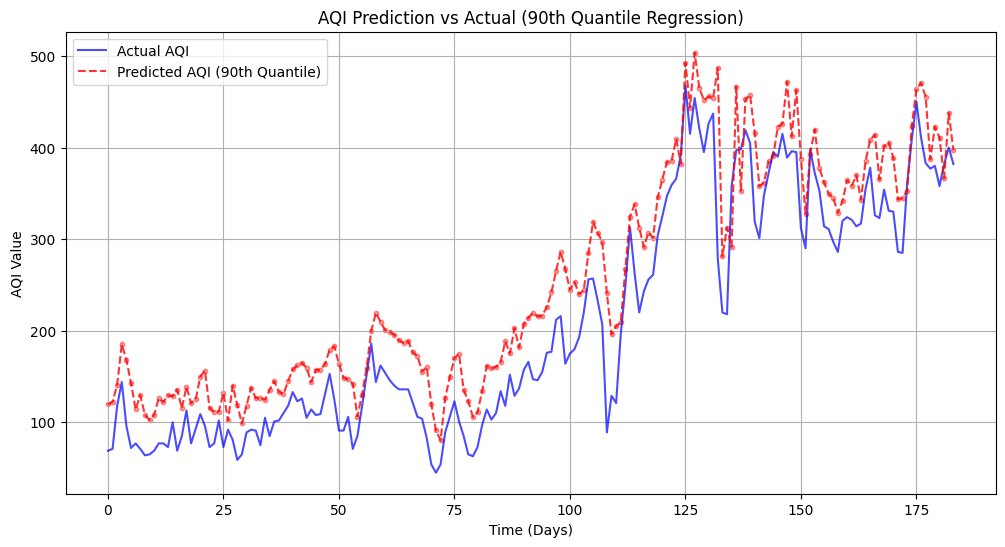

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(actuals, label="Actual AQI", color="blue", linestyle="-", alpha=0.7)

# Plot predicted values
plt.plot(predictions, label="Predicted AQI (90th Quantile)", color="red", linestyle="--", alpha=0.8)

# Scatter plot for better visibility
plt.scatter(range(len(predictions)), predictions, color="red", alpha=0.4, s=10)

# Titles and labels
plt.title("AQI Prediction vs Actual (90th Quantile Regression)")
plt.xlabel("Time (Days)")
plt.ylabel("AQI Value")
plt.legend()
plt.grid(True)